#Predecir temperatura en Hermosillo

Kevin David Ruiz González

##Librerías

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import gzip

from google.colab import drive


In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


##Importar dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Redes/Temperatura/2022-05-erno_hora_L1.csv", encoding="latin_1", skiprows=6)
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
0,yyyy-mm-dd HH:MM:SS,°C,%,m/s,m/s,deg,mm,hPa,W/m^2
1,2022-05-01 00:00:00,24.21,23.17,0.73,1.63,356.4,0.0,984.041,-2.3
2,2022-05-01 01:00:00,23.75,24.08,1.56,2.5,71.9,0.0,983.777,-2.5
3,2022-05-01 02:00:00,22.92,24.69,1.319,2.41,87.0,0.0,983.506,-1.5
4,2022-05-01 03:00:00,22.14,25.44,0.958,1.66,101.3,0.0,983.536,-2.3
...,...,...,...,...,...,...,...,...,...
740,2022-05-31 19:00:00,32.76,24.59,4.643,7.44,252.6,0.0,982.052,112.6
741,2022-05-31 20:00:00,30.72,29.91,4.465,7.32,247.5,0.0,982.557,6.5
742,2022-05-31 21:00:00,29.29,32.29,3.315,5.43,252.4,0.0,983.079,-1.7
743,2022-05-31 22:00:00,28.03,33.77,2.668,4.45,250.3,0.0,983.764,-1.7


Eliminar fila innecesaria

In [ ]:
df = df.tail(-1)
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
1,2022-05-01 00:00:00,24.21,23.17,0.73,1.63,356.4,0.0,984.041,-2.3
2,2022-05-01 01:00:00,23.75,24.08,1.56,2.5,71.9,0.0,983.777,-2.5
3,2022-05-01 02:00:00,22.92,24.69,1.319,2.41,87.0,0.0,983.506,-1.5
4,2022-05-01 03:00:00,22.14,25.44,0.958,1.66,101.3,0.0,983.536,-2.3
5,2022-05-01 04:00:00,22.08,25.53,1.419,1.97,80.7,0.0,983.698,-2.0
...,...,...,...,...,...,...,...,...,...
740,2022-05-31 19:00:00,32.76,24.59,4.643,7.44,252.6,0.0,982.052,112.6
741,2022-05-31 20:00:00,30.72,29.91,4.465,7.32,247.5,0.0,982.557,6.5
742,2022-05-31 21:00:00,29.29,32.29,3.315,5.43,252.4,0.0,983.079,-1.7
743,2022-05-31 22:00:00,28.03,33.77,2.668,4.45,250.3,0.0,983.764,-1.7


Cambio de formato

In [ ]:
df.loc['TIMESTAMP']=pd.to_datetime(
    df['TIMESTAMP'],
    format = '%Y-%m-%d %H:%M:%S'
)
df = df[:-1]
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
1,2022-05-01 00:00:00,24.21,23.17,0.73,1.63,356.4,0.0,984.041,-2.3
2,2022-05-01 01:00:00,23.75,24.08,1.56,2.5,71.9,0.0,983.777,-2.5
3,2022-05-01 02:00:00,22.92,24.69,1.319,2.41,87.0,0.0,983.506,-1.5
4,2022-05-01 03:00:00,22.14,25.44,0.958,1.66,101.3,0.0,983.536,-2.3
5,2022-05-01 04:00:00,22.08,25.53,1.419,1.97,80.7,0.0,983.698,-2.0
...,...,...,...,...,...,...,...,...,...
740,2022-05-31 19:00:00,32.76,24.59,4.643,7.44,252.6,0.0,982.052,112.6
741,2022-05-31 20:00:00,30.72,29.91,4.465,7.32,247.5,0.0,982.557,6.5
742,2022-05-31 21:00:00,29.29,32.29,3.315,5.43,252.4,0.0,983.079,-1.7
743,2022-05-31 22:00:00,28.03,33.77,2.668,4.45,250.3,0.0,983.764,-1.7


Volviendo la fecha el key

In [ ]:
df = df.set_index("TIMESTAMP")
df.sort_index(inplace=True)
df

,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
TIMESTAMP,,,,,,,,
2022-05-01 00:00:00,24.21,23.17,0.73,1.63,356.4,0.0,984.041,-2.3
2022-05-01 01:00:00,23.75,24.08,1.56,2.5,71.9,0.0,983.777,-2.5
2022-05-01 02:00:00,22.92,24.69,1.319,2.41,87.0,0.0,983.506,-1.5
2022-05-01 03:00:00,22.14,25.44,0.958,1.66,101.3,0.0,983.536,-2.3
2022-05-01 04:00:00,22.08,25.53,1.419,1.97,80.7,0.0,983.698,-2.0
...,...,...,...,...,...,...,...,...
2022-05-31 19:00:00,32.76,24.59,4.643,7.44,252.6,0.0,982.052,112.6
2022-05-31 20:00:00,30.72,29.91,4.465,7.32,247.5,0.0,982.557,6.5
2022-05-31 21:00:00,29.29,32.29,3.315,5.43,252.4,0.0,983.079,-1.7


Repetir proceso para cada csv

In [ ]:
df = pd.DataFrame()
dir = "/content/drive/MyDrive/Redes/Temperatura/"
for file in os.listdir(dir):
  sample_df = pd.read_csv(dir+file, encoding="latin_1", skiprows=6)
  sample_df = sample_df.tail(-1)
  sample_df.loc['TIMESTAMP']=pd.to_datetime(
    sample_df['TIMESTAMP'],
    format = '%Y-%m-%d %H:%M:%S'
  )
  sample_df = sample_df[:-1]
  sample_df = sample_df.set_index("TIMESTAMP")
  sample_df.sort_index(inplace=True)
  if df.empty:
    df = sample_df
  else:
    df = pd.concat([df, sample_df])

In [ ]:
df.sort_index(inplace=True)
df

,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
TIMESTAMP,,,,,,,,
2022-04-01 00:00:00,20.25,31.42,0.625,1.33,157.8,0.0,984.995,-2.2
2022-04-01 01:00:00,19.32,33.92,0.544,1.41,183.0,0.0,985.129,-2.2
2022-04-01 02:00:00,18.39,36.83,1.025,1.76,74.7,0.0,985.454,-2.0
2022-04-01 03:00:00,17.85,36.53,1.392,2.47,84.3,0.0,985.326,-2.1
2022-04-01 04:00:00,16.4,36.43,1.796,3.07,78.9,0.0,985.188,-1.0
...,...,...,...,...,...,...,...,...
2023-05-22 22:00:00,28.8,16.75,1.563,3.01,269.0,0.0,987.063,-2.9
2023-05-22 23:00:00,28.23,18.31,1.645,2.74,273.9,0.0,987.33,-2.9
2023-05-23 00:00:00,26.92,21.33,1.236,2.79,217.1,0.0,987.708,-2.5


Guardar todo en un csv

In [ ]:
df.to_csv("output.csv")

## Procesamiento Dataset

In [ ]:
df = pd.read_csv("output.csv")
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
0,2022-04-01 00:00:00,20.25,31.42,0.625,1.33,157.8,0.0,984.995,-2.2
1,2022-04-01 01:00:00,19.32,33.92,0.544,1.41,183.0,0.0,985.129,-2.2
2,2022-04-01 02:00:00,18.39,36.83,1.025,1.76,74.7,0.0,985.454,-2.0
3,2022-04-01 03:00:00,17.85,36.53,1.392,2.47,84.3,0.0,985.326,-2.1
4,2022-04-01 04:00:00,16.40,36.43,1.796,3.07,78.9,0.0,985.188,-1.0
...,...,...,...,...,...,...,...,...,...
9199,2023-05-22 22:00:00,28.80,16.75,1.563,3.01,269.0,0.0,987.063,-2.9
9200,2023-05-22 23:00:00,28.23,18.31,1.645,2.74,273.9,0.0,987.330,-2.9
9201,2023-05-23 00:00:00,26.92,21.33,1.236,2.79,217.1,0.0,987.708,-2.5
9202,2023-05-23 01:00:00,25.74,24.31,0.516,1.15,183.3,0.0,987.870,-2.1


In [ ]:
df.isna().sum()

TIMESTAMP      0
Temp_Avg      74
RH_Avg        40
WSpeed_Avg    38
WSpeed_Max    35
WDir_Avg      38
Rain_Tot      38
Press_Avg     35
Rad_Avg       41
dtype: int64

Eliminar datos vacíos usando el promedio de temperatura

In [ ]:
df = df.fillna(df.mean())

<ipython-input-18-04e87d67d337>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [ ]:
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
0,2022-04-01 00:00:00,20.25,31.42,0.625,1.33,157.8,0.0,984.995,-2.2
1,2022-04-01 01:00:00,19.32,33.92,0.544,1.41,183.0,0.0,985.129,-2.2
2,2022-04-01 02:00:00,18.39,36.83,1.025,1.76,74.7,0.0,985.454,-2.0
3,2022-04-01 03:00:00,17.85,36.53,1.392,2.47,84.3,0.0,985.326,-2.1
4,2022-04-01 04:00:00,16.40,36.43,1.796,3.07,78.9,0.0,985.188,-1.0
...,...,...,...,...,...,...,...,...,...
9199,2023-05-22 22:00:00,28.80,16.75,1.563,3.01,269.0,0.0,987.063,-2.9
9200,2023-05-22 23:00:00,28.23,18.31,1.645,2.74,273.9,0.0,987.330,-2.9
9201,2023-05-23 00:00:00,26.92,21.33,1.236,2.79,217.1,0.0,987.708,-2.5
9202,2023-05-23 01:00:00,25.74,24.31,0.516,1.15,183.3,0.0,987.870,-2.1


In [ ]:
df["TIMESTAMP"] = pd.to_datetime(df['TIMESTAMP']).dt.date

In [ ]:
df

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,Rain_Tot,Press_Avg,Rad_Avg
0,2022-04-01,20.25,31.42,0.625,1.33,157.8,0.0,984.995,-2.2
1,2022-04-01,19.32,33.92,0.544,1.41,183.0,0.0,985.129,-2.2
2,2022-04-01,18.39,36.83,1.025,1.76,74.7,0.0,985.454,-2.0
3,2022-04-01,17.85,36.53,1.392,2.47,84.3,0.0,985.326,-2.1
4,2022-04-01,16.40,36.43,1.796,3.07,78.9,0.0,985.188,-1.0
...,...,...,...,...,...,...,...,...,...
9199,2023-05-22,28.80,16.75,1.563,3.01,269.0,0.0,987.063,-2.9
9200,2023-05-22,28.23,18.31,1.645,2.74,273.9,0.0,987.330,-2.9
9201,2023-05-23,26.92,21.33,1.236,2.79,217.1,0.0,987.708,-2.5
9202,2023-05-23,25.74,24.31,0.516,1.15,183.3,0.0,987.870,-2.1


In [ ]:
max = df.groupby('TIMESTAMP')['Temp_Avg'].max().reset_index()
max = max.rename(columns = {"Temp_Avg": "MaxTemp"})
max = max.set_index("TIMESTAMP")
max.sort_index(inplace=True)
max

,MaxTemp
TIMESTAMP,
2022-04-01,30.62
2022-04-02,31.27
2022-04-03,28.58
2022-04-04,27.22
2022-04-05,30.79
...,...
2023-05-19,33.19
2023-05-20,35.20
2023-05-21,36.52


In [ ]:
print(max.to_markdown())

| TIMESTAMP   |   MaxTemp |
|:------------|----------:|
| 2022-04-01  |   30.62   |
| 2022-04-02  |   31.27   |
| 2022-04-03  |   28.58   |
| 2022-04-04  |   27.22   |
| 2022-04-05  |   30.79   |
| 2022-04-06  |   34.45   |
| 2022-04-07  |   39.51   |
| 2022-04-08  |   35.24   |
| 2022-04-09  |   34.22   |
| 2022-04-10  |   30.46   |
| 2022-04-11  |   30.99   |
| 2022-04-12  |   28.01   |
| 2022-04-13  |   29.19   |
| 2022-04-14  |   33.08   |
| 2022-04-15  |   33.21   |
| 2022-04-16  |   33.54   |
| 2022-04-17  |   38.21   |
| 2022-04-18  |   40.53   |
| 2022-04-19  |   36.82   |
| 2022-04-20  |   35.23   |
| 2022-04-21  |   34.65   |
| 2022-04-22  |   31.98   |
| 2022-04-23  |   29.71   |
| 2022-04-24  |   31.82   |
| 2022-04-25  |   35.72   |
| 2022-04-26  |   35.72   |
| 2022-04-27  |   34.96   |
| 2022-04-28  |   33.31   |
| 2022-04-29  |   32.57   |
| 2022-04-30  |   35.01   |
| 2022-05-01  |   33.72   |
| 2022-05-02  |   33.88   |
| 2022-05-03  |   31.55   |
| 2022-05-04  |   32

## Dividir dataset

In [ ]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [ ]:
tr, vl, ts = train_val_test_split(max['MaxTemp'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (309,)
Tamaño set de validación: (38,)
Tamaño set de prueba: (40,)


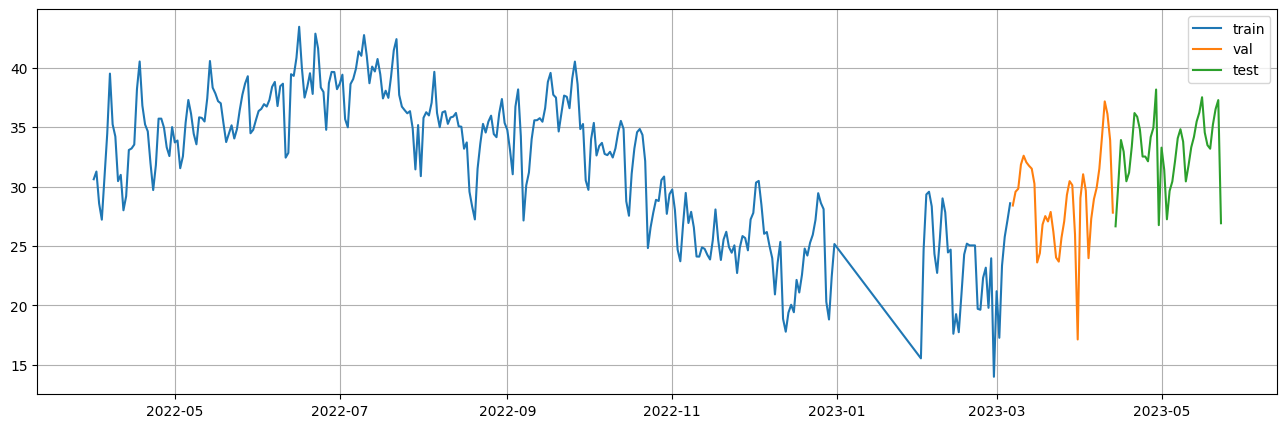

In [ ]:
fig,ax=plt.subplots(figsize=(16,5))
ax.plot(tr,label='train')
ax.plot(vl,label='val')
ax.plot(ts,label='test')
plt.grid('True')
plt.legend()

## Crear dataset preparado

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 1    # Registros de 1 dia consecutivas a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 dia a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (307, 1, 1), y_tr: (307, 1, 1)
Set de validación - x_vl: (36, 1, 1), y_vl: (36, 1, 1)
Set de prueba - x_ts: (38, 1, 1), y_ts: (38, 1, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]
    print("NFEATS = ", NFEATS)

    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)

    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #se usa para entrenar el escalardor porque son los datos conocidos
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [ ]:
# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


NFEATS =  1
Min x_tr/x_vl/x_ts sin escalamiento: 14.0/17.14/26.66
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.7867572156196945/-0.14023769100169803

Min y_tr/y_vl/y_ts sin escalamiento: 14.0/17.14/26.76
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.7867572156196945/-0.13344651952461817

Max x_tr/x_vl/x_ts sin escalamiento: 43.45/37.17/38.17
Max x_tr/x_vl/x_ts con escalamiento: 0.9999999999999998/0.5735144312393887/0.6414261460101864

Max y_tr/y_vl/y_ts sin escalamiento: 43.45/37.17/38.17
Max y_tr/y_vl/y_ts con escalamiento: 0.9999999999999998/0.5735144312393887/0.6414261460101864


In [ ]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 6 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 1 (dia) x 1 (feature)

In [ ]:
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

In [ ]:
optimizador = Adam(learning_rate=5e-2)
modelo.compile(
    optimizer = optimizador,
    loss = "mse",
)

In [ ]:
# Entrenamiento (aproximadamente 3 min usando GPU)
# CPU ~59 mins
# GPU  ~4 mins
EPOCHS = 3 # Hiperparámetro
BATCH_SIZE = 32 # Hiperparámetro
%time historia = modelo.fit( x = x_tr_s, y = y_tr_s,   batch_size = BATCH_SIZE,  epochs = EPOCHS,   validation_data = (x_vl_s, y_vl_s),     verbose=1 )

Epoch 1/3
10/10 [==============================] - 9s 54ms/step - loss: 0.1981 - val_loss: 0.1291
Epoch 2/3
10/10 [==============================] - 0s 7ms/step - loss: 0.0798 - val_loss: 0.0351
Epoch 3/3
10/10 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0487
CPU times: user 3.97 s, sys: 597 ms, total: 4.57 s
Wall time: 9.18 s


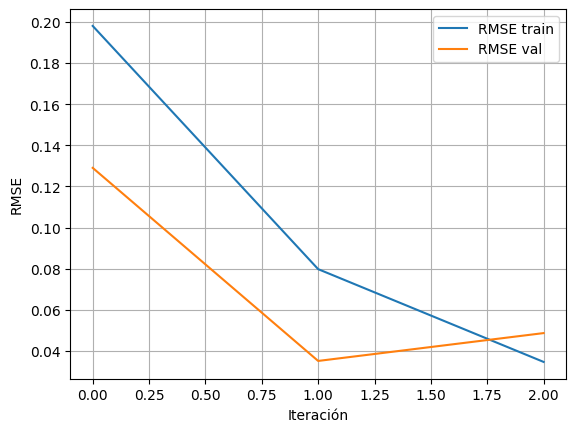

In [ ]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.grid('True')
plt.legend()

In [ ]:
# Cálculo de rmses para train, val y test
mse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
mse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
mse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  MSE train:\t {mse_tr:.3f}')
print(f'  MSE val:\t {mse_vl:.3f}')
print(f'  MSE test:\t {mse_ts:.3f}')

Comparativo desempeños:
  MSE train:	 0.032
  MSE val:	 0.049
  MSE test:	 0.050


## Predicción

In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

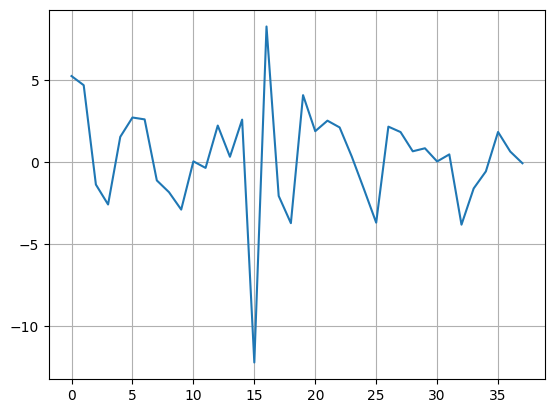

In [ ]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
minimo = np.min(errores)
maximo = np.max(errores)
plt.plot(errores);
plt.grid('True')

In [ ]:
print(f"El error va desde {minimo} a {maximo}")

El error va desde -12.220606079101561 a 8.258246688842775


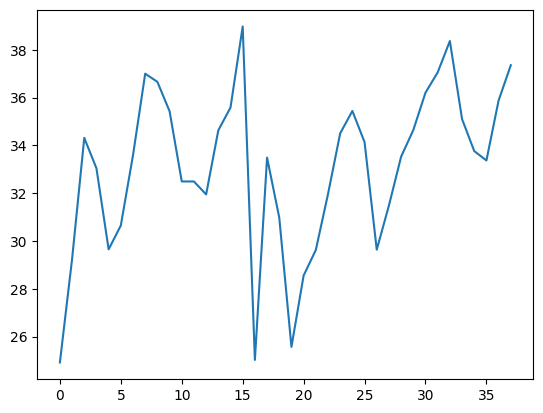

In [ ]:
plt.plot(y_ts_pred)